# pytorch beginer 用法

本文主要结合官方文档：[WRITING CUSTOM DATASETS, DATALOADERS AND TRANSFORMS](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)，[VISUALIZING MODELS, DATA, AND TRAINING WITH TENSORBOARD](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)以及[pytorch/tutorials/beginner_source](https://github.com/pytorch/tutorials/tree/master/beginner_source) 中的[Learning PyTorch with Examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) 进一步了解pytorch的基本用法。

## 数据处理

很多时候要花时间在准备数据上，比如网络上下载的纯数据，想要顺利地输入到自己定义的模型中，可能这一步要花些时间来处理。

pytorch提供了许多工具来让数据的夹在更容易，来使代码可读性更强。接下来用一个例子看看如何加载并处理数据。

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

该数据集是一个面部图片。在这里下载：https://download.pytorch.org/tutorial/faces.zip ，解压后文件夹置于data文件夹下。

首先看看csv数据：

In [2]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


展示一个图片看看：

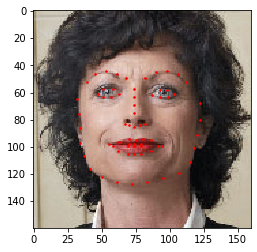

In [3]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

torch.utils.data.Dataset 是一个抽象类，代表一个数据集。自己定制的数据集应该继承Dataset 类，并重写__len__ 和__getitem__ 函数。前者是返回数据集的大小，后者用以支持索引dataset[i]来获取第i个sample。

现在为 face landmarks数据集**创建一个dataset类**。在 **__init__ 函数中读取csv文件**，将images的读取放在__getitem__中，这样可以避免一次性将所有数据都加载进内存。

设计数据集的sample为dict：{'image': image, 'landmarks': landmarks}，dataset会设置一个可选参数transform以在需要的时候作用到sample上。transform后面稍后再看。

In [5]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

现在初始化类并迭代数据samples，以4个samples为例：

0 (324, 215, 3) (68, 2)


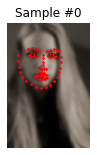

1 (500, 333, 3) (68, 2)


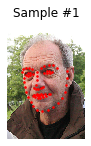

2 (250, 258, 3) (68, 2)


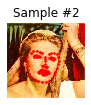

3 (434, 290, 3) (68, 2)


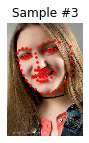

In [6]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

从上面的图片中可以看出samples大小是不一样的。而神经网络还是希望输入的数据是大小fixed的，所以需要对数据做预处理：

- Rescale: scale 图片
- RandomCrop: 随机切图. 这是 data augmentation.
- ToTensor: 将numpy的images转换为torch images(需要swap axes).

将它们都写为可调用的class，而不是简单的需要在调用时传参的函数。需要实现__call__方法，还有如有需要的__init__函数。然后就可以形如下列模式，直接像函数一样调用对象了：

```python
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```

注意看看这些transforms如何应用到images和landmarks上：

In [7]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

现在将transform 应用到一个sample上。比如我们想rescale image的较短边到256，并随机切成一个边长224的正方形，所以要使用Rescale 和RandomCrop 变换。torchvision.transforms.Compose 是自带的一个可以执行这些变换的。

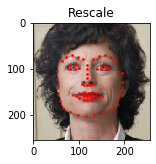

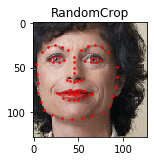

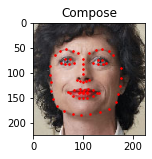

In [8]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

现在我们可以应用前面所述工具创建一个转换后的数据集了：

- 快速读取image
- 转换读取的image
- 因为数据转换是随机的，所以数据是增强的

迭代读取数据：

In [9]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


不过，由于只是简单地迭代数据，因此我们丢失了很多特征。比如：

- Batching 数据
- Shuffling 数据
- 使用multiprocessing 并行加载数据

torch.utils.data.DataLoader是一个迭代器，能提供上述功能。我们必须得清楚一些参数。其中之一是collate_fn。可以指定样本需要如何被batched。大多数情况下默认的方式即可。

In [10]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

BrokenPipeError: [Errno 32] Broken pipe

## Tensorboard

可以展示模型训练时的一些统计指标以对训练过程有基本的认识。Pytorch现在整合了TensorBoard，它是一个设计来可视化神经网络训练过程结果的工具。有了它可以可视化更丰富的内容。

接下来是一个例子，首先读取数据并做合适的变换。接着设置tensorboard并将数据写入tensorboard，然后就可以使用tensorboard了，包括查看训练数据，跟踪模型训练性能，以及评估训练后的模型性能。

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

以上是数据的前处理，接下来构建网络模型：

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

现在开始设置tensorboard，从torch.utils导入，并定义SummaryWriter，这是向tensorboard写数据的关键对象。

In [3]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

注意现在创建了新的文件夹runs/fashion_mnist_experiment_1。接下来把数据写入TensorBoard，使用make_grid

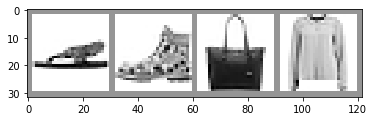

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

现在在本文件夹下打开命令行并运行：

```Shell
tensorboard --logdir=runs
```

然后就可以导航到 https://localhost:6006 查看交互式图形了。

tensorboard的一个亮点是能可视化复杂的模型结构。

In [5]:
writer.add_graph(net, images)
writer.close()

执行完上面命令后，刷新TensorBoard，就会看到网页导航栏有“GRAPHS”。点击进入，就能看到模型结构，双击每个节点，就能看到内部的结构。

接下来看看如何通过add_embedding方法来可视化高维数据为低维表示。

In [7]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

接下来将loss记录进TensorBoard，并通过plot_classes_preds函数看模型预测。首先是一些辅助函数：

In [8]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

然后训练模型，并使用add_scalar函数将结果写入TensorBoard，而不是输出到控制台。

In [9]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


现在在SCALARS标签下可以看到训练过程中loss的变化。最后可以看看如何评估模型。

In [10]:
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

最后在新的标签页可以看到结果。

## 跟着例子学习PyTorch

通过例子了解pytorch的基本概念。

PyTorch的核心是提供两个主要功能：

- n维张量，类似于numpy，但可以在GPU上运行；
- 自动区分以构建和训练神经网络。

### 张量

先使用 numpy 实现网络（更具体地可以参考:[numpy部分的手写神经网络](https://github.com/OuyangWenyu/hydrus/blob/master/3-numpy-examples/neural_network.py)），这里也做些记录，详见nn_basic.ipynb

Numpy 提供了一个n维的数组对象, 并提供了许多操纵这个数组对象的函数。Numpy 是科学计算的通用框架; Numpy 数组没有计算图, 也没有深度学习, 也没有梯度下降等方法实现的接口。但是可以很容易地使用 numpy 生成随机数据，并将产生的数据传入双层的神经网络,并实现这个网络的正向传播和反向传播:

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np

# N是批尺寸参数；D_in是输入维度
# H是隐藏层维度；D_out是输出维度
N, D_in, H, D_out = 64, 1000, 100, 10

# 产生随机输入和输出数据
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# 随机初始化权重
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

learning_rate = 1e-6
for t in range(500):
    # 前向传播：计算预测值y
    h = x.dot(w1)
    h_relu = np.maximum(h, 0)
    y_pred = h_relu.dot(w2)

    # 计算并显示loss（损失）
    loss = np.square(y_pred - y).sum()
    print(t, loss)

    # 反向传播，计算w1、w2对loss的梯度
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0
    grad_w1 = x.T.dot(grad_h)

    # 更新权重
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

Numpy 是一个伟大的框架, 但它不能利用 GPU 加速它数值计算，而对于现代的深度神经网络, GPU 往往是提供 50倍或更大的加速,所以 numpy 不足以满足现在深度学习的需求。

PyTorch提供了Tensor，其在概念上与 numpy 数组相同，也是一个n维数组, 不过PyTorch 提供了很多能在这些 Tensor 上操作的函数。

像 numpy 数组一样, PyTorch Tensor 也和numpy的数组对象一样不了解深度学习,计算图和梯度下降，它们只是科学计算的通用工具；

然而不像 numpy, PyTorch Tensor 可以利用 GPU 加速他们的数字计算。

要在 GPU 上运行 PyTorch 张量, 只需将其转换为新的数据类型.

将 PyTorch Tensor 生成的随机数据传入双层的神经网络. 就像上面的 numpy 例子一样,
我们需要手动实现网络的正向传播和反向传播:

In [ ]:
# -*- coding: utf-8 -*-

import torch


dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# N是批尺寸大小； D_in 是输入维度；
# H 是隐藏层维度； D_out 是输出维度
N, D_in, H, D_out = 64, 1000, 100, 10

# 产生随机输入和输出数据
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# 随机初始化权重
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(500):
    # 前向传播：计算预测值y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # 计算并输出loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

    # 反向传播，计算w1、w2对loss的梯度
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # 使用梯度下降更新权重
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

### 自动求导

对于小型的两层网络而言，手动实现反向传递并不重要，但对于大型的复杂网络而言，这变得非常麻烦。

幸运的是，我们可以使用**自动微分** 来自动计算神经网络中的反向传播。PyTorch中的 autograd软件包提供了这个功能。使用autograd时，您的网络正向传递将定义一个 计算图；图中的节点为张量，图中的边为从输入张量产生输出张量的函数。通过该图进行反向传播，可以轻松计算梯度。

这听起来很复杂，在实践中非常简单。**每个张量代表计算图中的一个节点**。如果 x是一个张量，并且有 x.requires_grad=True，那么x.grad就是另一个张量，代表着x相对于某个标量值的梯度。

通过使用PyTorch张量和autograd来实现网络就不再需要手动实现网络的反向传播：

In [ ]:
# -*- coding: utf-8 -*-
import torch

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# N是批尺寸大小；D_in是输入维度；
# H是隐藏层维度；D_out是输出维度 
N, D_in, H, D_out = 64, 1000, 100, 10

# 产生随机输入和输出数据，将requires_grad置为False，意味着我们不需要在反向传播时候计算这些值的梯度
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# 产生随机权重tensor，将requires_grad设置为True，意味着我们希望在反向传播时候计算这些值的梯度
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
    # 前向传播：使用tensor的操作计算预测值y。
    # 由于w1和w2有requires_grad=True,涉及这些张量的操作将让PyTorch构建计算图，从而允许自动计算梯度。
    # 由于我们不再手工实现反向传播，所以不需要保留中间值的引用。
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    # 计算并输出loss
    # loss是一个形状为(1,)的张量
    # loss.item()是这个张量对应的python数值
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # 使用autograd计算反向传播,这个调用将计算loss对所有requires_grad=True的tensor的梯度。
    # 这次调用后，w1.grad和w2.grad将分别是loss对w1和w2的梯度张量。
    loss.backward()

    # 使用梯度下降更新权重。对于这一步，我们只想对w1和w2的值进行原地改变；不想为更新阶段构建计算图，
    # 所以我们使用torch.no_grad()上下文管理器防止PyTorch为更新构建计算图
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # 反向传播之后手动将梯度置零，原因在后面第三节nn到底是什么一节中简单补充说明
        w1.grad.zero_()
        w2.grad.zero_()

在底层，每一个原始的**自动求导运算**实际上是**两个在Tensor上运行的函数**。其中，**forward**函数计算从输入Tensors获得的输出Tensors。而**backward**函数接收输出Tensors对于某个标量值的梯度，并且计算输入Tensors相对于该相同标量值的梯度。

在PyTorch中，可以很容易地通过定义**torch.autograd.Function**的子类并实现**forward和backward函数**，来**定义自己的自动求导运算**。然后，我们可以通过**构造实例**并**像调用函数一样调用它**，并传递包含输入数据的张量。

接下来一个例子定义一个自己的定制autograd函数来执行ReLU，并用它来实现一个两层神经网络。

可以看到首先继承了torch.autograd.Function类。

重写的forward函数接受一个包含input的tensor并返回一个包含输出的tensor。ctx是一个context对象，可以用来为 backward 计算保存信息。您可以使用  ctx.save_for_backward 方法缓存任意对象，以便在 后面 backward 传递中使用。clamp函数就是类似ReLU形式的函数，min=0 就是ReLU。所以前向计算就是在最后这步计算ReLU，然后记得要把input放入计算图。

在backward传递中，我们得到一个张量，它包含了loss相对于**输出**的梯度，我们需要计算loss相对于**输入**的梯度。首先注意backward只是计算梯度，并不更新权重！ReLU的反向梯度是怎么算的可以参考：[ReLU函数详解及反向传播中的梯度求导](https://blog.csdn.net/oBrightLamp/article/details/84326978)，注意前向过程完整版是x向量经ReLU变r向量，再和目标值比较得到误差向量e。所以反向传播，就是求$\frac{\partial e}{\partial x}$

In [ ]:
# -*- coding: utf-8 -*-
import torch


class MyReLU(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input


dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs.
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Create random Tensors for weights.
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
    # To apply our Function, we use Function.apply method. We alias this as 'relu'.
    relu = MyReLU.apply

    # Forward pass: compute predicted y using operations; we compute
    # ReLU using our custom autograd operation.
    y_pred = relu(x.mm(w1)).mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

为了更清楚地理解backward函数的意义，这里补充一些参考：[探讨pytorch中nn.Module与nn.autograd.Function的backward()函数](https://cloud.tencent.com/developer/article/1149993).

backward()在pytorch中是一个经常出现的函数，我们一般会在更新loss的时候使用它，比如loss.backward()。通过对loss进行backward来实现从输出到输入的自动求梯度运算。对该函数溯源下可以发现这个backward来源于torch.autograd.backward。这个函数我们可能不常见，那么这个函数在哪儿呢，就在Tensor这个类中（loss就是一个tensor），而**Tensor这个类中有一个函数：backward()函数**。这个函数**返回的就是torch.autograd.backward()**。也就是说，我们在训练中输入我们数据，然后经过一系列神经网络运算，最后计算loss，然后loss.backward()。这里的backward()归根究底就是，上面说的这个函数。

好，那么接下来就说明两个backward，一个nn.Module中的backward()，一个torch.autograd.Function中的backward()，其实有一个是假的backward()。

很容易发现，我们在自己定义一个全新的网络层的时候会**继承nn.Module**，但是我们只需要实现__init__和forward()即可，不需要实现也**没必要实现backward()函数**。即使你实现了，你继承了nn.Module并且编写了一个backward()函数，在实际运行中该backward函数也并不会执行。这就是假的backward函数，不会在pytorch的自动求梯度图中执行。因为目的是要实现对loss的backward，在forward中进行操作的时候，已经对torch.autograd.Function的subclass进行了操作。也就是说在我们**对tensor进行每一步操作运算的时候都会生成一个Function类的子类，里面定了好了forward和backward操作**，最后连成**计算图**.

那既然不建议在nn.Module中定义backward。那能不能自己定义backward函数？

可以通过**继承torch.autograd.Function来定义**！官方教程：[PyTorch: Defining new autograd functions](https://github.com/jcjohnson/pytorch-examples#pytorch-defining-new-autograd-functions)，这就是上面的例子。MyReLU继承了torch.autograd.Function。那么我们在什么情况下需要自己定义？

平常使用的nn.Module其实说白了就是一层包装(Contain)，比如nn.Conv2继承了nn.Module，但是里面的核心函数是torch.nn.function.conv2d，为什么要包装下，原因很简单，**为了方便**，因为我们使用的卷积层是有参数的，这些参数是可以学习的(learnable parameters)。在这个包装类中我们通过torch.nn.parameter的Parameter类把参数进行包装然后传递给torch.nn.function中的函数进行计算，这样也就简化了我们的操作。

那么什么时候需要使用torch.autograd.Function去定义自己的层，在**有些操作通过组合pytorch中已有的层实现不了的时候**，比如你要实现一个新的梯度下降算法，那么就可以尝试着写这些东西。但是要注意，因为这个涉及到了底层，你需要forward和backward一起写，然后自己写对中间变量的操作，比如gradinput以及gradoutput。比如：

```python
class my_function(Function):
    def forward(self, input, parameters):
        self.saved_for_backward = [input, parameters]
        # output = [对输入和参数进行的操作，这里省略]
        return output

    def backward(self, grad_output):
        input, parameters = self.saved_for_backward
        # grad_input = [求 forward(input)关于 parameters 的导数] * grad_output
        return grad_input

# 然后通过定义一个Module来包装一下

class my_module(nn.Module):
    def __init__(self, ...):
        super(my_module, self).__init__()
        self.parameters = # 初始化一些参数

    def backward(self, input):
        output = my_function(input, self.parameters) # 在这里执行你之前定义的function!
        return output
```

这样你就可以通过自定义层然后包装，然后来使用了。包不包装对于执行效率的影响几乎可以不计。

接下来通过示例基本的ann进一步理解如何运用pytorch包.

## 基本神经网络

简单复习下步骤：

获取数据，包括归一化处理—>构建神经网络结果，主要是定义layer，完成参数初始化—>定义forward函数，主要是每层计算输出，包括定义激活函数—>定义损失函数、优化算法—>注意要先将数据定义到张量中，然后调用函数式地调用神经网络对象以调用forward计算—>计算loss并由loss张量完成自动梯度计算反向传播—>调用优化算法的step完成参数更新—>梯度归零（也可以放在loss反向传播之前），开始新一轮循环参数更新。

上述步骤中，除了重写Module之外，直接利用Sequential构建神经网络结构也是一种常见做法。

接下来利用pytorch写一个神经网络的示例来自课程《Mordern deep learning in Python》。

Reading in and transforming data...


C:\Users\hust2\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 0, cost: 0.251691, acc: 0.96
Epoch: 1, cost: 0.117666, acc: 0.97
Epoch: 2, cost: 0.082470, acc: 0.97
Epoch: 3, cost: 0.054635, acc: 0.97
Epoch: 4, cost: 0.060924, acc: 0.97
Epoch: 5, cost: 0.052717, acc: 0.97
Epoch: 6, cost: 0.039973, acc: 0.98
Epoch: 7, cost: 0.034754, acc: 0.97
Epoch: 8, cost: 0.044111, acc: 0.98
Epoch: 9, cost: 0.050160, acc: 0.98
Epoch: 10, cost: 0.031708, acc: 0.98
Epoch: 11, cost: 0.042624, acc: 0.98
Epoch: 12, cost: 0.030264, acc: 0.98
Epoch: 13, cost: 0.032563, acc: 0.98
Epoch: 14, cost: 0.027656, acc: 0.98


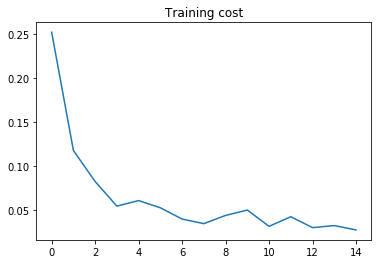

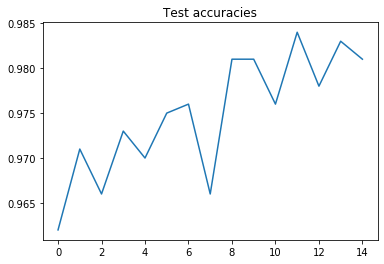

In [3]:
import os
import pandas as pd
import numpy as np


def get_normalized_data():
    """获取数据"""
    print("Reading in and transforming data...")

    if not os.path.exists('data/mnist/train.csv'):
        print('Looking for data/mnist/train.csv')
        print('You have not downloaded the data and/or not placed the files in the correct location.')
        print('Please get the data from: https://www.kaggle.com/c/digit-recognizer')
        print('Place train.csv in the folder data adjacent to the class folder')
        exit()

    df = pd.read_csv('data/mnist/train.csv')
    data = df.values.astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    Y = data[:, 0]

    Xtrain = X[:-1000]
    Ytrain = Y[:-1000]
    Xtest = X[-1000:]
    Ytest = Y[-1000:]

    # normalize the data
    mu = Xtrain.mean(axis=0)
    std = Xtrain.std(axis=0)
    np.place(std, std == 0, 1)
    Xtrain = (Xtrain - mu) / std
    Xtest = (Xtest - mu) / std

    return Xtrain, Xtest, Ytrain, Ytest

import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch import optim
import torch

# 第一步是load data，这里采用的是deep learning里的hello world，即识别手写数字的数据集，来自kaggle。
# get the data,
# no need to split now, the fit() function will do it
Xtrain, Xtest, Ytrain, Ytest = get_normalized_data()

# get shapes
_, D = Xtrain.shape
K = len(set(Ytrain))

# 第二步是构建网络结构，使用pytorch构建神经网络要比直接通过numpy手写简单很多，这里先构建一个sequential（和Keras类似），然后逐层添加网络结构即可。
model = torch.nn.Sequential()
# 逐层添加网络即可，在pytorch中是采用add_module()函数。第一个参数是当前层的命名，可以取任何想要的名称。第二个参数就是该层。层要么是linear transformation，要么是activation
# 比如第一层，Linear,参数D是输入的神经元个数，第二个参数500是输出的神经元个数
model.add_module("dense1", torch.nn.Linear(D, 500))
model.add_module("relu1", torch.nn.ReLU())
model.add_module("dense2", torch.nn.Linear(500, 300))
model.add_module("relu2", torch.nn.ReLU())
model.add_module("dense3", torch.nn.Linear(300, K))
# 第三步是构建loss函数，loss函数详情可参考http://pytorch.org/docs/master/nn.html#loss-functions
loss = torch.nn.CrossEntropyLoss(size_average=True)
# 第四步是设置优化函数，Adam是一种常用的优化算法，是一种改良的GD算法。算法需要神经网络的parameters作为参数。
optimizer = optim.Adam(model.parameters())


# 第五步是定义训练过程和预测过程，这部分也是相对最难掌握的一部分。这部分相对TensorFlow和Theano都会麻烦一些。


def train(model, loss, optimizer, inputs, labels):
    """训练过程主要包括：包装输入输出到Variable变量，初始化优化函数，前向传播，反向传播，以及参数更新，详情见每步解释"""
    # 为什么要包装变量到Variable：把Tensor包装到Variable中，它就会开始保存所有计算历史。因此每次运算都会稍微多一些cost；另一方面，在训练循环外部对Variable进行计算操作相对容易。不包装也是可以计算的，并且后面的pytorch版本有柯南高就不需要Variable的这一步了
    inputs = Variable(inputs, requires_grad=False)
    labels = Variable(labels, requires_grad=False)

    # pytorch的梯度计算是累计的，这对有些神经网络是比较好的，因此这里初始化为0
    optimizer.zero_grad()

    # 直接调用model的前向函数即可得到输出
    logits = model.forward(inputs)

    # 然后计算loss
    output = loss.forward(logits, labels)

    # 接着就是进行反向传播计算
    output.backward()

    # 最后是更新参数
    optimizer.step()

    return output.item()


def predict(model, inputs):
    inputs = Variable(inputs, requires_grad=False)
    logits = model.forward(inputs)
    # argmax函数是给出axis维上数组中最大数的索引
    return logits.data.numpy().argmax(axis=1)


# 第六步定义各类超参数并开始训练过程
# 首先是将numpy变量都设置为torch中的张量，注意要指定数据类型
Xtrain = torch.from_numpy(Xtrain).float()
Ytrain = torch.from_numpy(Ytrain).long()
Xtest = torch.from_numpy(Xtest).float()

epochs = 15
batch_size = 32  # 每个batch的大小
n_batches = Xtrain.size()[0] // batch_size  # batch的个数

costs = []
test_accuracies = []
for i in range(epochs):
    cost = 0.
    for j in range(n_batches):
        Xbatch = Xtrain[j * batch_size:(j + 1) * batch_size]
        Ybatch = Ytrain[j * batch_size:(j + 1) * batch_size]
        cost += train(model, loss, optimizer, Xbatch, Ybatch)

    Ypred = predict(model, Xtest)
    acc = np.mean(Ytest == Ypred)
    print("Epoch: %d, cost: %f, acc: %.2f" % (i, cost / n_batches, acc))

    costs.append(cost / n_batches)
    test_accuracies.append(acc)

# 第七步是将训练过程可视化,# EXERCISE: plot test cost + training accuracy too。一般都是把cost和accuracy都可视化出来
# plot the results
plt.plot(costs)
plt.title('Training cost')
plt.show()

plt.plot(test_accuracies)
plt.title('Test accuracies')
plt.show()

在模型训练中，dropout是个比较重要的环节，以下给出一个示例。

有dropout的神经网络的区别：
一个是在神经网络结构中增加dropout层；
另一个，注意dropout有两个mode，一是对train data的，一个是对test data的。在train data中进行dropout，但是在test data中是不用的"""

In [ ]:
# https://deeplearningcourses.com/c/data-science-deep-learning-in-theano-tensorflow
# https://www.udemy.com/data-science-deep-learning-in-theano-tensorflow
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

# Note: is helpful to look at keras_example.py first


import numpy as np
import matplotlib.pyplot as plt
from util import get_normalized_data

import torch
from torch.autograd import Variable
from torch import optim

# get the data, same as Theano + Tensorflow examples
# no need to split now, the fit() function will do it
Xtrain, Xtest, Ytrain, Ytest = get_normalized_data()

# get shapes
_, D = Xtrain.shape
K = len(set(Ytrain))

# Note: no need to convert Y to indicator matrix


# the model will be a sequence of layers
model = torch.nn.Sequential()

# ANN with layers [784] -> [500] -> [300] -> [10]
# NOTE: the "p" is p_drop, not p_keep
model.add_module("dropout1", torch.nn.Dropout(p=0.2))
model.add_module("dense1", torch.nn.Linear(D, 500))
model.add_module("relu1", torch.nn.ReLU())
model.add_module("dropout2", torch.nn.Dropout(p=0.5))
model.add_module("dense2", torch.nn.Linear(500, 300))
model.add_module("relu2", torch.nn.ReLU())
model.add_module("dropout3", torch.nn.Dropout(p=0.5))
model.add_module("dense3", torch.nn.Linear(300, K))
# Note: no final softmax!
# just like Tensorflow, it's included in cross-entropy function


# define a loss function
# other loss functions can be found here:
# http://pytorch.org/docs/master/nn.html#loss-functions
loss = torch.nn.CrossEntropyLoss(size_average=True)
# Note: this returns a function!
# e.g. use it like: loss(logits, labels)


# define an optimizer
# other optimizers can be found here:
# http://pytorch.org/docs/master/optim.html
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# define the training procedure
# i.e. one step of gradient descent
# there are lots of steps
# so we encapsulate it in a function
# Note: inputs and labels are torch tensors
def train(model, loss, optimizer, inputs, labels):
    # set the model to training mode
    # because dropout has 2 different modes!
    model.train()

    inputs = Variable(inputs, requires_grad=False)
    labels = Variable(labels, requires_grad=False)

    # Reset gradient
    optimizer.zero_grad()

    # Forward
    logits = model.forward(inputs)
    output = loss.forward(logits, labels)

    # Backward
    output.backward()

    # Update parameters
    optimizer.step()

    # what's the difference between backward() and step()?

    return output.item()


# similar to train() but not doing the backprop step
def get_cost(model, loss, inputs, labels):
    # set the model to testing mode
    # because dropout has 2 different modes!
    model.eval()

    inputs = Variable(inputs, requires_grad=False)
    labels = Variable(labels, requires_grad=False)

    # Forward
    logits = model.forward(inputs)
    output = loss.forward(logits, labels)

    return output.item()


# define the prediction procedure
# also encapsulate these steps
# Note: inputs is a torch tensor
def predict(model, inputs):
    # set the model to testing mode
    # because dropout has 2 different modes!
    model.eval()

    inputs = Variable(inputs, requires_grad=False)
    logits = model.forward(inputs)
    return logits.data.numpy().argmax(axis=1)


# return the accuracy
# labels is a torch tensor
# to get back the internal numpy data
# use the instance method .numpy()
def score(model, inputs, labels):
    predictions = predict(model, inputs)
    return np.mean(labels.numpy() == predictions)


### prepare for training loop ###

# convert the data arrays into torch tensors
Xtrain = torch.from_numpy(Xtrain).float()
Ytrain = torch.from_numpy(Ytrain).long()
Xtest = torch.from_numpy(Xtest).float()
Ytest = torch.from_numpy(Ytest).long()

# training parameters
epochs = 15
batch_size = 32
n_batches = Xtrain.size()[0] // batch_size

# things to keep track of
train_costs = []
test_costs = []
train_accuracies = []
test_accuracies = []

# main training loop
for i in range(epochs):
    cost = 0
    test_cost = 0
    for j in range(n_batches):
        Xbatch = Xtrain[j * batch_size:(j + 1) * batch_size]
        Ybatch = Ytrain[j * batch_size:(j + 1) * batch_size]
        cost += train(model, loss, optimizer, Xbatch, Ybatch)

    # we could have also calculated the train cost here
    # but I wanted to show you that we could also return it
    # from the train function itself
    train_acc = score(model, Xtrain, Ytrain)
    test_acc = score(model, Xtest, Ytest)
    test_cost = get_cost(model, loss, Xtest, Ytest)

    print("Epoch: %d, cost: %f, acc: %.2f" % (i, test_cost, test_acc))

    # for plotting
    train_costs.append(cost / n_batches)
    train_accuracies.append(train_acc)
    test_costs.append(test_cost)
    test_accuracies.append(test_acc)

# plot the results
plt.plot(train_costs, label='Train cost')
plt.plot(test_costs, label='Test cost')
plt.title('Cost')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train accuracy')
plt.plot(test_accuracies, label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()